In [2]:
# use this notebook to compare the zero-shot and fine-tuned performance of Sundial model
import os
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from ainode.core.model.sundial.modeling_sundial import SundialForPrediction
from ainode.core.training.notebooks.max_heap import MaxHeap

# not a bad config
num_samples = 10
lookback_length = 1440
prediction_length = 96

In [4]:
# load model and dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# refactor the following path to your own environment
model_path='/data/yongzao/timecho-ainode/iotdb-core/ainode/ainode/core/data/ainode/models/weights'
raw_model = SundialForPrediction.from_pretrained(os.path.join(model_path, '_sundial'))
raw_model = raw_model.to(device)
fine_tune_model = SundialForPrediction.from_pretrained(os.path.join(model_path, 'sundialWEA_4'))
fine_tune_model = fine_tune_model.to(device)
print(next(raw_model.parameters()).device, next(fine_tune_model.parameters()).device)

cuda:0 cuda:0


In [5]:
# refactor the following path to your own environment
dataset_path = '/data/yongzao/dataset'
df = pd.read_csv(os.path.join(dataset_path, 'weather.csv'))
value = torch.tensor(df["root.eg.weather.s20"].values, dtype=torch.float32)
value = value.to(device)
print(value.device)

cuda:0


In [6]:
# compare zero-shot and fine-tuned loss
heap = MaxHeap()
start_index = 16000 - lookback_length
end_index = start_index + 1000
# end_index = 20000 - lookback_length - prediction_length

raw_total_mse_loss = torch.tensor(0.0).to(device)
raw_total_mae_loss = torch.tensor(0.0).to(device)
fine_tune_total_mse_loss = torch.tensor(0.0).to(device)
fine_tune_total_mae_loss = torch.tensor(0.0).to(device)
total_count = torch.tensor(0.0).to(device)
for i in range(start_index, end_index):
    # prepare input & ground truth
    seqs = value[i:(i+lookback_length)].unsqueeze(0)
    truth = value[i+lookback_length:(i+lookback_length+prediction_length)]

    # generate forecast
    output_raw = raw_model.generate(seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True)
    output_raw = output_raw[0].mean(dim=0)
    output_fine_tune = fine_tune_model.generate(seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True)
    output_fine_tune = output_fine_tune[0].mean(dim=0)

    # sum the loss
    cur_raw_mse_loss = F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    cur_raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    cur_fine_tune_mse_loss = F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
    cur_fine_tune_mae_loss = F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()

    mse_improve = (cur_raw_mse_loss - cur_fine_tune_mse_loss) / cur_raw_mse_loss * 100
    heap.push(i, mse_improve.item())

    raw_total_mse_loss += cur_raw_mse_loss
    raw_total_mae_loss += cur_raw_mae_loss
    fine_tune_total_mse_loss += cur_fine_tune_mse_loss
    fine_tune_total_mae_loss += cur_fine_tune_mae_loss
    total_count += 1

    if i % 100 == 0:
        print(f"Processed {i - start_index + 1} samples...")

# compare the loss
raw_total_mse_loss = raw_total_mse_loss / total_count
raw_total_mae_loss = raw_total_mae_loss / total_count
fine_tune_total_mse_loss = fine_tune_total_mse_loss / total_count
fine_tune_total_mae_loss = fine_tune_total_mae_loss / total_count
print(f"Sundial zero-shot MSE Loss: {raw_total_mse_loss:.4f}, MAE Loss: {raw_total_mae_loss:.4f}")
print(f"Sundial fine-tuned MSE Loss: {fine_tune_total_mse_loss:.4f}, MAE Loss: {fine_tune_total_mae_loss:.4f}")
print(f"Improvement of MSE Loss: {((raw_total_mse_loss - fine_tune_total_mse_loss) / raw_total_mse_loss * 100):.2f}%")
print(f"Improvement of MAE Loss: {((raw_total_mae_loss - fine_tune_total_mae_loss) / raw_total_mae_loss * 100):.2f}%")

# record the best 20 points
for i in range(20):
    index, mse_improve = heap.pop()
    print(f"Index: {index}, MSE Improvement: {mse_improve:.2f}%")


Processed 41 samples...
Processed 141 samples...
Processed 241 samples...
Processed 341 samples...
Processed 441 samples...
Processed 541 samples...
Processed 641 samples...
Processed 741 samples...
Processed 841 samples...
Processed 941 samples...
Sundial zero-shot MSE Loss: 79.2299, MAE Loss: 6.0274
Sundial fine-tuned MSE Loss: 77.0974, MAE Loss: 5.8742
Improvement of MSE Loss: 2.69%
Improvement of MAE Loss: 2.54%
Index: 14687, MSE Improvement: 91.65%
Index: 14605, MSE Improvement: 88.40%
Index: 14682, MSE Improvement: 84.76%
Index: 15483, MSE Improvement: 78.23%
Index: 14674, MSE Improvement: 74.66%
Index: 14629, MSE Improvement: 74.46%
Index: 14586, MSE Improvement: 73.33%
Index: 15226, MSE Improvement: 70.87%
Index: 15233, MSE Improvement: 70.70%
Index: 15372, MSE Improvement: 69.92%
Index: 15367, MSE Improvement: 67.07%
Index: 14686, MSE Improvement: 66.75%
Index: 14565, MSE Improvement: 65.82%
Index: 14620, MSE Improvement: 65.61%
Index: 14679, MSE Improvement: 63.63%
Index: 145

Sundial zero-shot MSE Loss: 15.1475, MAE Loss: 3.2476
Sundial fine-tuned MSE Loss: 10.1153, MAE Loss: 2.1878
Improvement of MSE Loss: 33.22%
Improvement of MAE Loss: 32.63%


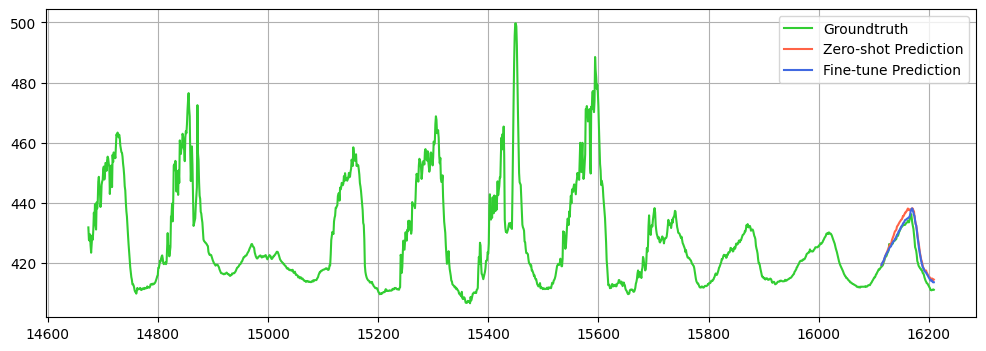

In [18]:
# Sample visualization
start = 14674

# prepare input & ground truth
seqs = value[start:(start+lookback_length)].unsqueeze(0)
truth = value[start+lookback_length:(start+lookback_length+prediction_length)]

# generate forecast
output_raw = raw_model.generate(seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True)
output_raw = output_raw[0].mean(dim=0)
output_fine_tune = fine_tune_model.generate(seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True)
output_fine_tune = output_fine_tune[0].mean(dim=0)

raw_mse_loss = F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
fine_tune_mse_loss = F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
fine_tune_mae_loss = F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
print(f"Sundial zero-shot MSE Loss: {raw_mse_loss:.4f}, MAE Loss: {raw_mae_loss:.4f}")
print(f"Sundial fine-tuned MSE Loss: {fine_tune_mse_loss:.4f}, MAE Loss: {fine_tune_mae_loss:.4f}")
print(f"Improvement of MSE Loss: {((raw_mse_loss - fine_tune_mse_loss) / raw_mse_loss * 100):.2f}%")
print(f"Improvement of MAE Loss: {((raw_mae_loss - fine_tune_mae_loss) / raw_mae_loss * 100):.2f}%")

# visualize
plt.figure(figsize=(12, 4))
plt.plot(df["root.eg.weather.s20"][start:(start + lookback_length + prediction_length)], color="limegreen", label="Groundtruth")
plt.plot(range(start + lookback_length, start + lookback_length + prediction_length), output_raw.cpu(), color="tomato", label="Zero-shot Prediction")
plt.plot(range(start + lookback_length, start + lookback_length + prediction_length), output_fine_tune.cpu(), color="royalblue", label="Fine-tune Prediction")
plt.legend()
plt.grid()
plt.show()